## 1. Постановка задачи


Необходимо произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать модель на новых клиентах.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [4]:
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice CustomerID         Country  
0  12/1/2010 8:26       2.55      17850  United Kingdom  
1  12/1/2010 8:26       3.39      17850  United Kingdom  
2  12/1/2010 8:26       2.75      17850  United Kingdom  
3  12/1/2010 8:26       3.39      17850  United Kingdom  
4  12/1/2010 8:26       3.39      17850  United Kingdom

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [6]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
data.loc[:, 'InvoiceDate'] = pd.to_datetime( data.loc[:, 'InvoiceDate'])

## 3. Предобработка и очистка данных

Избавимся от дубликатов

In [8]:
print(f' Duplicates number: {data.duplicated().sum()}')
data.drop_duplicates(inplace=True)
data.shape[0]

 Duplicates number: 5268


536641

In [9]:
mask = data['Quantity'] < 0
negative_quantity = data[mask]
print()
print(f'Count of entries with a negative number: {negative_quantity.shape[0]}')
print()
negative_quantity.head()


Count of entries with a negative number: 10587



InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

            InvoiceDate  UnitPrice CustomerID         Country  
141 2010-12-01 09:41:00      27.50      14527  United Kingdom  
154 2010-12-01 09:49:00       4.65      15311  United Kingdom  
235 2010-12-01 10:24:00       1.65      17548  United Kingdom  
236 2010-12-01 10:24:00       0.29      17548  United Kingdom  
237 2010-12-01 10:24:00       0.29      17548  United Kingdom

In [10]:
count = 0
for value in negative_quantity['InvoiceNo'].values:
    if value[0] != 'C':
        count += 1
print(count)

1336


In [11]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24

In [12]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)

nb_products_per_basket['order_canceled'].value_counts(normalize=True)*100

0    83.533123
1    16.466877
Name: order_canceled, dtype: float64

In [13]:
count = 0
for index, row in negative_quantity.iterrows():
    if row['StockCode'] in data['StockCode'].values and row['CustomerID'] in data['CustomerID'].values and -int(row['Quantity']) in data['Quantity'].values:
        count += 1
            
print(negative_quantity.shape[0] == count)

False


In [14]:
count = 0
mask = data['StockCode'] != 'D'
for index, row in negative_quantity.iterrows():
    if row['StockCode'] in data[mask]['StockCode'].values and row['CustomerID'] in data[mask]['CustomerID'].values and -int(row['Quantity']) in data[mask]['Quantity'].values and row['StockCode'] != 'D':
        count += 1
            
print(negative_quantity[negative_quantity['StockCode'] != 'D'].shape[0] == count)

False


In [16]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)

data['QuantityCanceled'] = quantity_canceled
data['QuantityCanceled'].sum()

245266.0

In [17]:
mask = data['Quantity'] < 0
df = data[~mask]
df.shape[0]

526054

In [18]:
data_contains = df['StockCode'].str.contains(r'^[a-zA-Z]+', regex=True)

unique_ls = []

for i in data_contains.index:
    if data_contains[i] == True:
        unique_ls.append(df['StockCode'][i])
        
set(unique_ls)

{'AMAZONFEE',
 'B',
 'BANK CHARGES',
 'C2',
 'DCGS0003',
 'DCGS0004',
 'DCGS0069',
 'DCGS0070',
 'DCGS0076',
 'DCGSSBOY',
 'DCGSSGIRL',
 'DOT',
 'M',
 'PADS',
 'POST',
 'S',
 'gift_0001_10',
 'gift_0001_20',
 'gift_0001_30',
 'gift_0001_40',
 'gift_0001_50',
 'm'}

In [19]:
df_filt = df[~data_contains]
df_filt

InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice CustomerID         Country  \
0      2010-12-01 08:26:00       2.55      17850  United Kingdom   
1      2010-12-01 08:26:00       3.39      17850  United Kingdom   
2      2010-12-01 08:26:00       2.75      17850  United Kingdom   
3      2010-12-01 08:26:00       3.39      17850  United Kingdom   
4      2010-12-01 08:26:00       3.39      17850  United Kingdom   
...                    ...        ...        ...             ...   
541904 2011-12-09 12:50:00       0.85      12680          France   
541905 2011-12-09 12:50:00       2.10      12680          France   
541906 2011-12-09 12:50:00       4.15      12680          France   
541907 2011-12-09 12:50:00       4.15      12680          France   
541908 2011-12-09 12:50:00       4.95      12680          France   

        QuantityCanceled  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  
...                  ...  
541904               0.0  
541905               0.0  
541906               0.0  
541907               0.0  
541908               0.0  

[523660 rows x 9 columns]

In [20]:
df_filt = df_filt[~(df_filt['UnitPrice'] == 0)]
df_filt.shape[0]

522504

## 4. Разведывательный анализ данных

In [21]:
df = df_filt

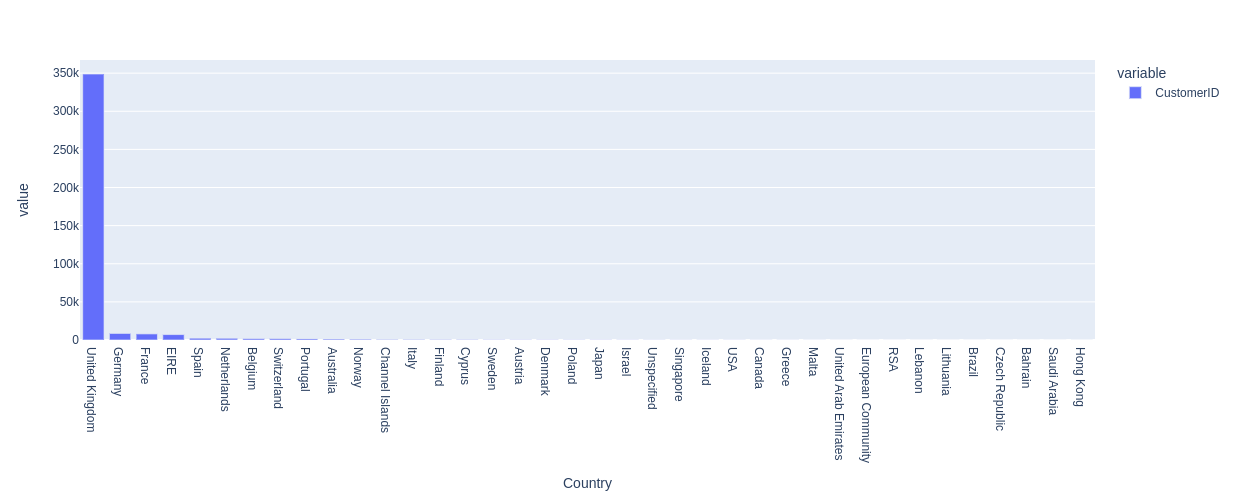

In [22]:
country_clients = df.groupby(['Country'])['CustomerID'].count().sort_values(ascending=False)

fig = px.bar(country_clients, height = 500)
fig.show()

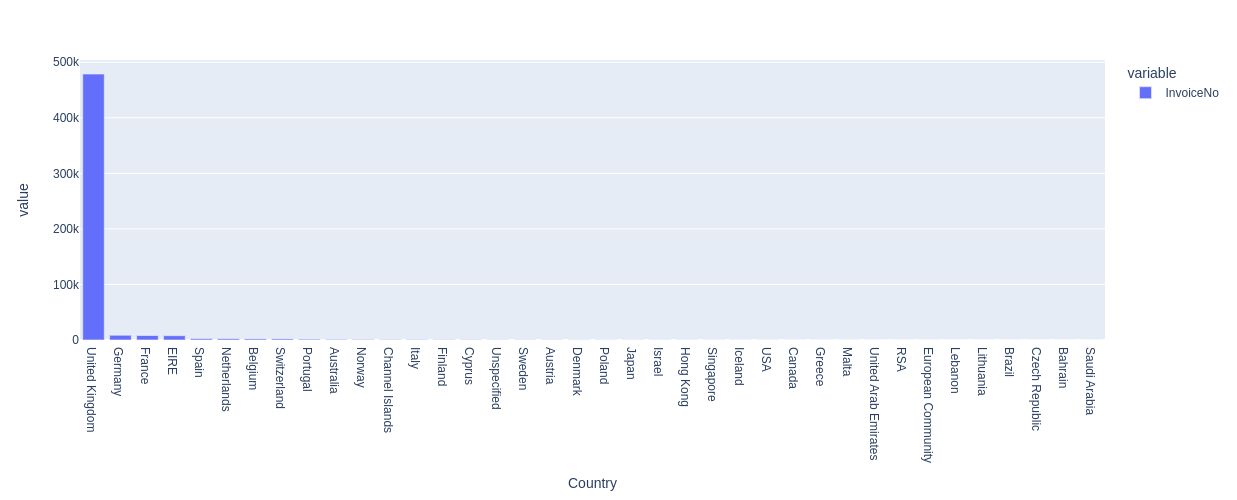

In [23]:
most_orders = df.groupby(['Country'])['InvoiceNo'].count().sort_values(ascending=False)

fig = px.bar(most_orders, height=500)
fig.show()


In [24]:
df['TotalPrice'] = (df['Quantity'] - df['QuantityCanceled']) * df['UnitPrice']
df['TotalPrice'].mean()

18.70451942952278

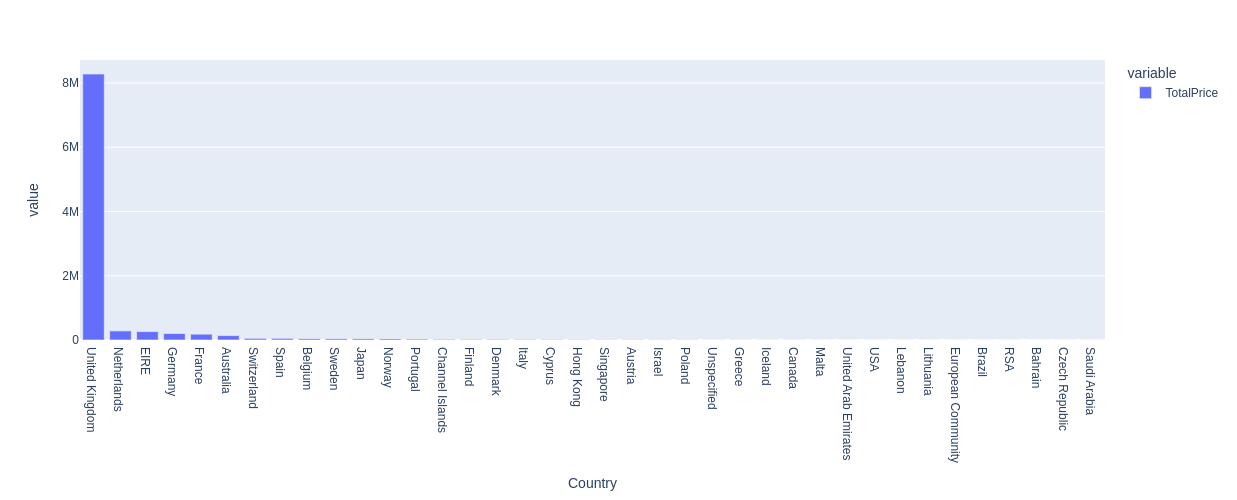

In [25]:
proceeds = df.groupby(['Country'])['TotalPrice'].sum().sort_values(ascending=False)

fig = px.bar(proceeds, height=500)
fig.show()

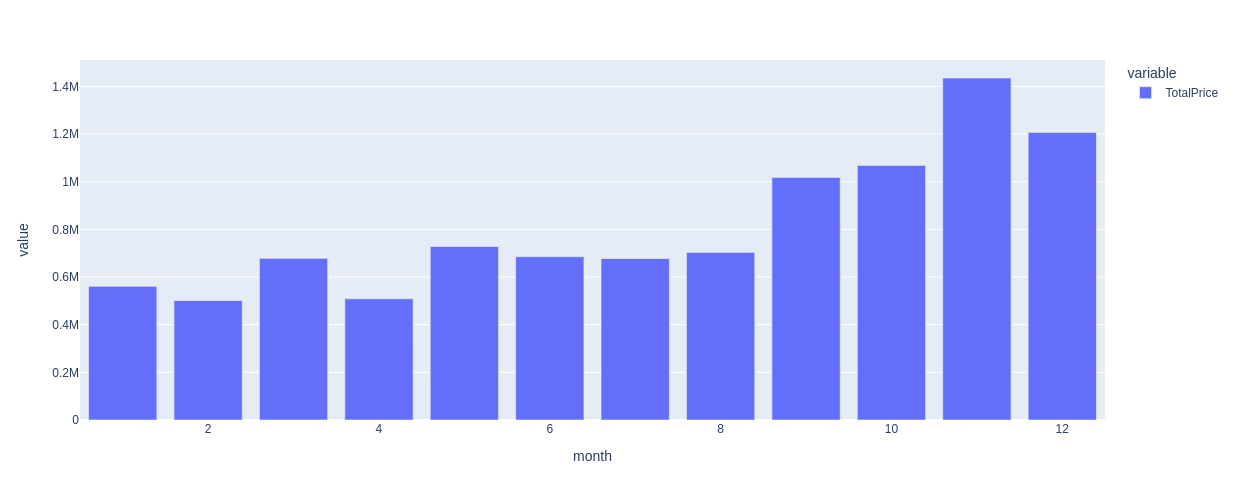

In [26]:
df.loc[:, 'InvoiceDate'] = pd.to_datetime(df.loc[:, 'InvoiceDate'])

df['month'] = df['InvoiceDate'].dt.month
df['day_of_week'] = df['InvoiceDate'].dt.day_of_week
df['hour'] = df['InvoiceDate'].dt.hour

proceeds_by_month = df.groupby(['month'])['TotalPrice'].sum()

fig = px.bar(proceeds_by_month, height=500)
fig.show()

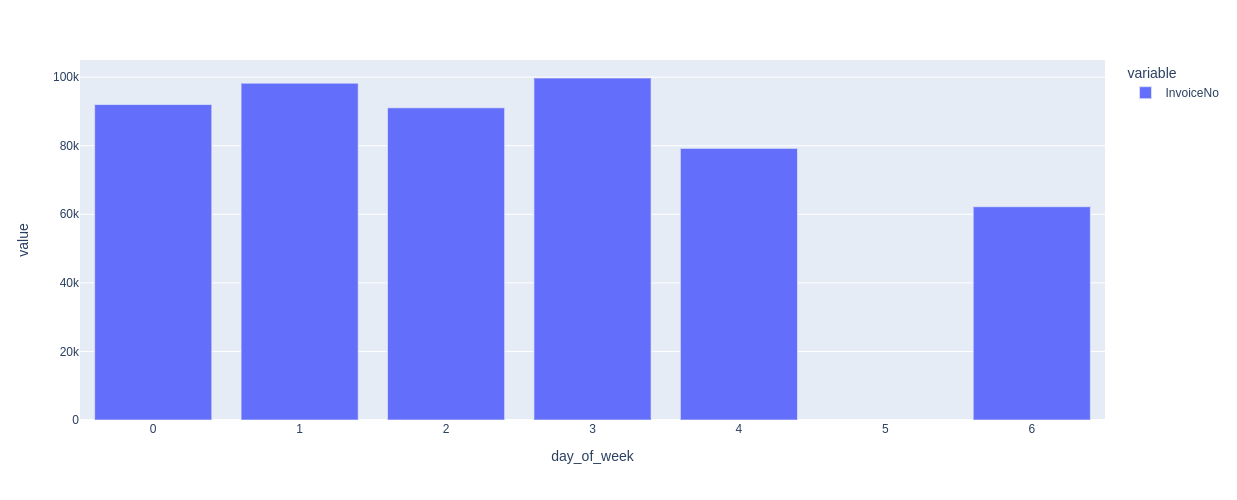

In [27]:
day_of_week = df.groupby(['day_of_week'])['InvoiceNo'].count()

fig = px.bar(day_of_week, height = 500)
fig.show()

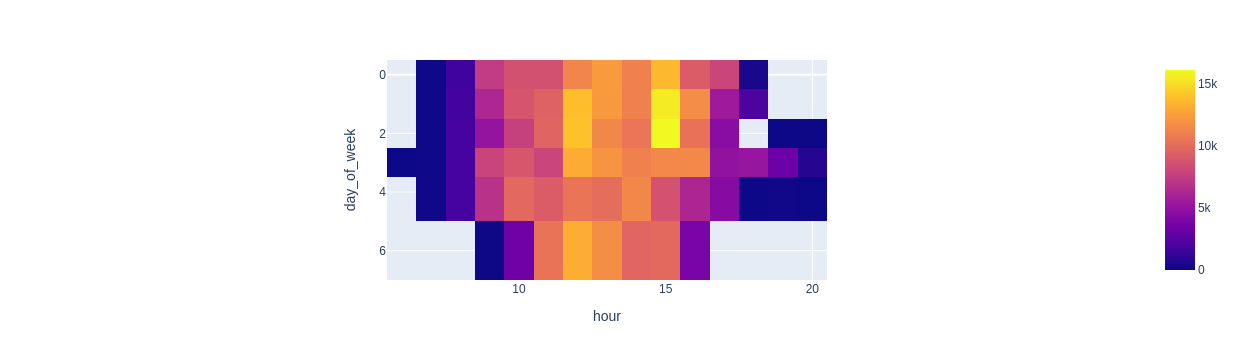

In [28]:
df['day_of_month'] = df['InvoiceDate'].dt.day

day_of_month = df.groupby(['day_of_week', 'hour'], as_index=False)['InvoiceNo'].count().rename(columns={'InvoiceNo':'order_count'})

pivot = pd.pivot_table(
    day_of_month,
    values = 'order_count',
    index = 'day_of_week',
    columns = 'hour',
    aggfunc = 'mean'
)

fig = px.imshow(pivot)
fig.show()

 ## 5. RFM-сегментация клиентов

In [29]:
rfm_table = df.groupby(['CustomerID'])[['InvoiceNo', 'TotalPrice']].agg({'TotalPrice':'sum', 'InvoiceNo':'nunique'}).rename(columns={'TotalPrice':'Monetary', 'InvoiceNo':'Frequency'})
rfm_table['Recency'] = (pd.to_datetime('2011-12-10') - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days
rfm_table

Monetary  Frequency  Recency
CustomerID                              
12346           0.00          1      325
12347        4310.00          7        2
12348        1437.24          4       75
12349        1457.55          1       18
12350         294.40          1      310
...              ...        ...      ...
18280         180.60          1      277
18281          80.82          1      180
18282         176.60          2        7
18283        2039.58         16        3
18287        1837.28          3       42

[4334 rows x 3 columns]

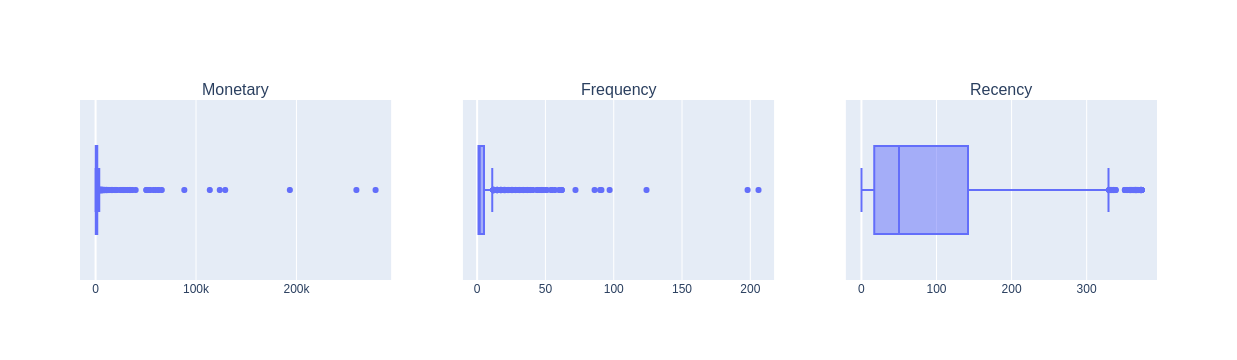

In [30]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Monetary","Frequency", "Recency"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

In [31]:
frequency_95 = rfm_table['Frequency'].quantile(0.95)
monetary_95 = rfm_table['Monetary'].quantile(0.95)

rfm_table_cleaned = rfm_table[(rfm_table['Frequency'] <= frequency_95)&(rfm_table['Monetary'] <= monetary_95)]
rfm_table_cleaned.shape[0]

4044

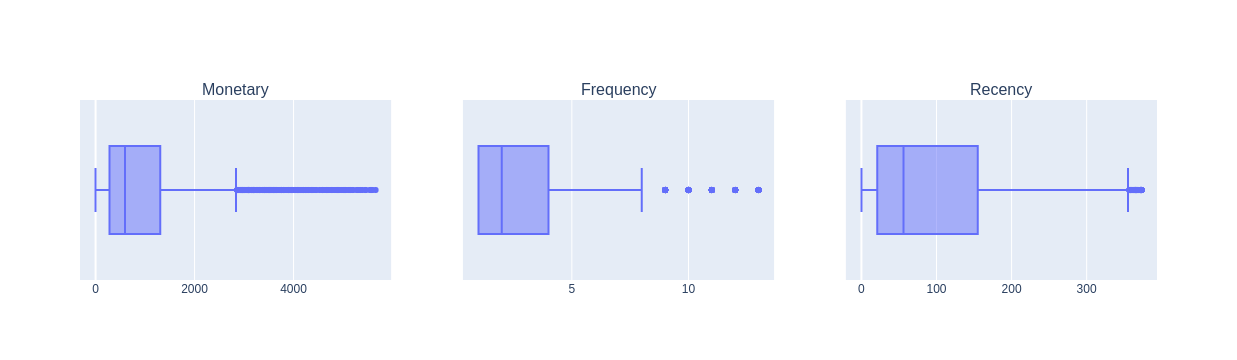

In [32]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Monetary", "Frequency", "Recency"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show()

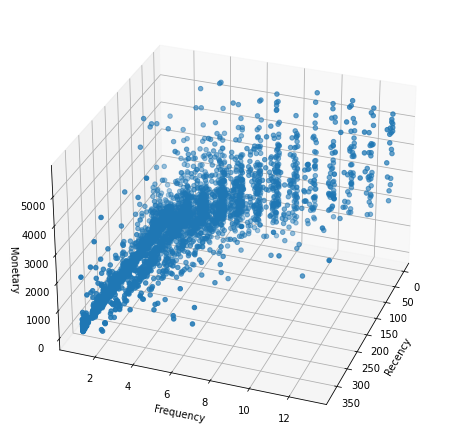

In [33]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

pipeline.fit(rfm_table_cleaned)
rfm_table_processed = pipeline.transform(rfm_table_cleaned)

rfm_table_processed = pd.DataFrame(rfm_table_processed, columns = ['axis-1', 'axis-2'])
pipeline['pca'].explained_variance_ratio_

array([0.67747053, 0.24012744])

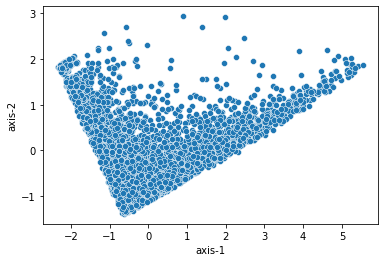

In [35]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

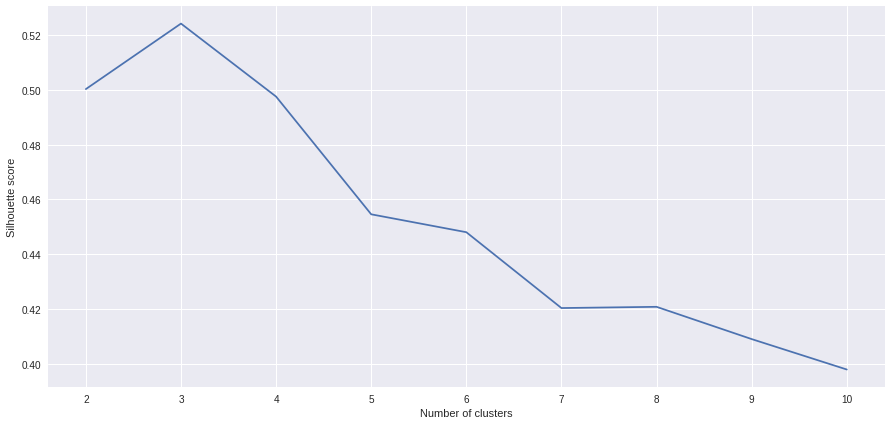

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
plt.style.use('seaborn')

def get_silhouette(X, num_clusters):
    kmeans = KMeans(n_clusters = num_clusters, random_state = 42)
    
    kmeans.fit(X)
    
    silhouette = silhouette_score(X, kmeans.labels_)
    
    return silhouette

silhouette_ls = []
for n in range(2, 11):
    silhouette_ls.append(get_silhouette(rfm_table_processed, n))
    
fig = plt.figure(figsize=(15,7))

lineplot = sns.lineplot(x = [x for x  in range(2,11)], y = silhouette_ls)

lineplot.set_xlabel('Number of clusters')
lineplot.set_ylabel('Silhouette score');

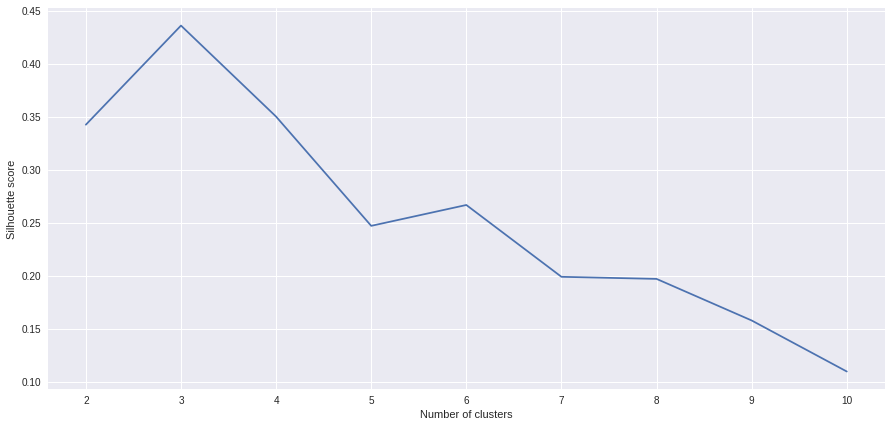

In [37]:
from sklearn.mixture import GaussianMixture

def get_silhouette(X, num_clusters):
    gaussian = GaussianMixture(n_components = num_clusters, random_state = 42)
    
    gaussian.fit(X)
    silhouette = silhouette_score(X, gaussian.predict(X))
    
    return silhouette

silhouette_ls = []
for n in range(2, 11):
    silhouette_ls.append(get_silhouette(rfm_table_processed, n))
    
fig = plt.figure(figsize=(15,7))

lineplot = sns.lineplot(x = [x for x  in range(2,11)], y = silhouette_ls)

lineplot.set_xlabel('Number of clusters')
lineplot.set_ylabel('Silhouette score');

In [39]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(rfm_table_processed)

labels = kmeans.labels_

rfm_table_processed['labels'] = labels

rfm_table_processed['labels'].value_counts()

2    2269
0     999
1     776
Name: labels, dtype: int64

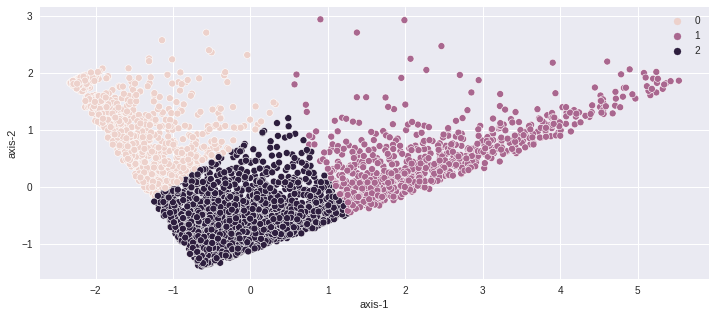

In [40]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
);

In [41]:
rfm_table_cleaned['labels'] = labels
cluster_group_table = round(rfm_table_cleaned.groupby('labels').mean(), 2)
cluster_group_table

Monetary  Frequency  Recency
labels                              
0         386.28       1.40   253.47
1        2657.75       7.07    31.94
2         660.07       2.33    51.22

In [42]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()

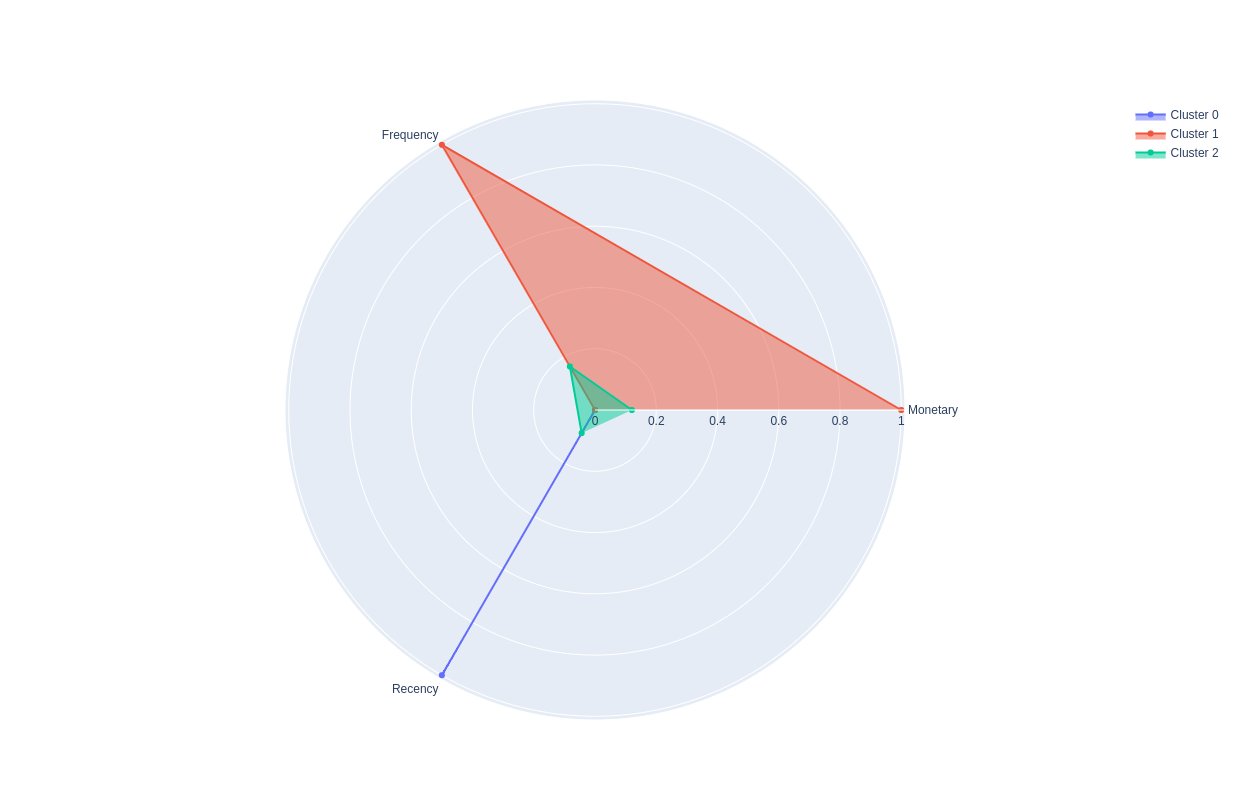

In [43]:
plot_cluster_profile(cluster_group_table, 3) 

In [44]:
rfm_table_cleaned.drop('labels', axis=1, inplace=True)

In [45]:
from sklearn.manifold import TSNE
pipeline = Pipeline([('scaler', StandardScaler()), ('t_sne', TSNE(perplexity=50, random_state=100))])

rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns = ['axis-1', 'axis-2'])
pipeline['t_sne'].kl_divergence_

0.5527210235595703

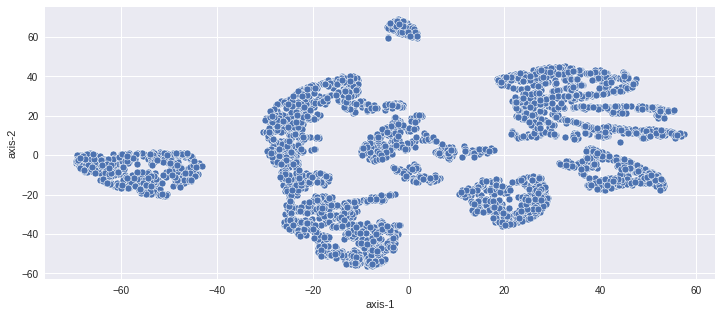

In [46]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

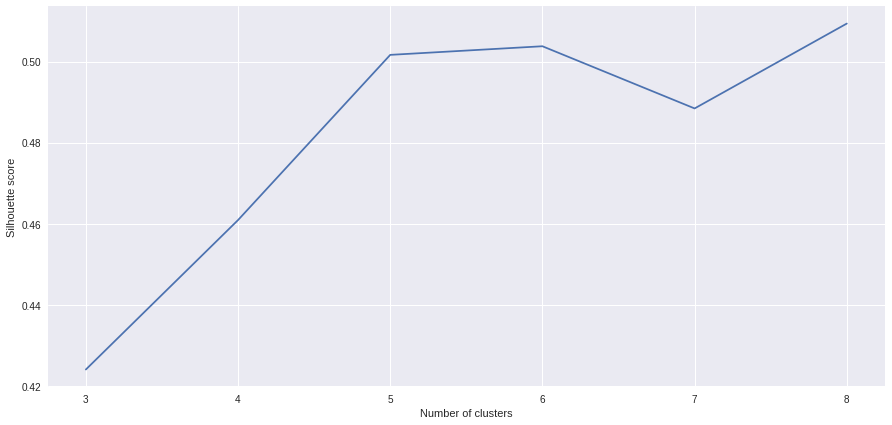

In [47]:
def get_silhouette(X, num_clusters):
    kmeans = KMeans(n_clusters = num_clusters, random_state = 42)
    
    kmeans.fit(X)
    
    silhouette = silhouette_score(X, kmeans.labels_)
    
    return silhouette

silhouette_ls = []
for n in range(3, 9):
    silhouette_ls.append(get_silhouette(rfm_table_processed, n))
    
fig = plt.figure(figsize=(15,7))

lineplot = sns.lineplot(x = [x for x  in range(3,9)], y = silhouette_ls)

lineplot.set_xlabel('Number of clusters')
lineplot.set_ylabel('Silhouette score');

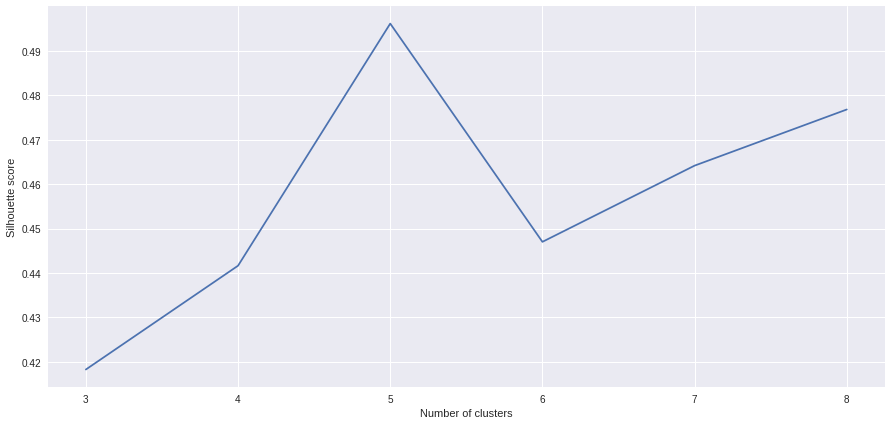

In [48]:
def get_silhouette(num_clusters, X):
    guassian = GaussianMixture(n_components = num_clusters, random_state = 42)
    
    guassian.fit(X)
    
    silhouette = silhouette_score(X, guassian.predict(X))
    
    return silhouette

silhouette_ls = []

for n in range(3,9):
    silhouette_ls.append(get_silhouette(n, rfm_table_processed))
    
fig = plt.figure(figsize=(15,7))

lineplot = sns.lineplot(x = [x for x in range(3,9)], y = silhouette_ls)

lineplot.set_ylabel('Silhouette score')
lineplot.set_xlabel('Number of clusters');

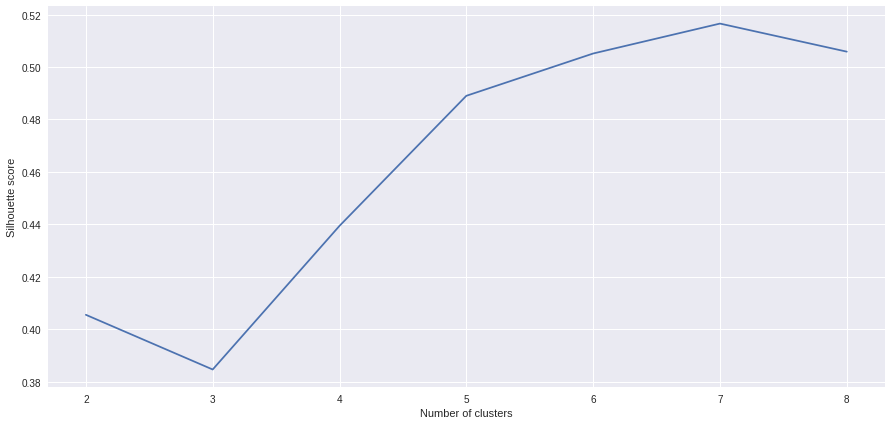

In [49]:
from sklearn.cluster import AgglomerativeClustering

def get_silhouette(num_clusters, X):
    agg_model = AgglomerativeClustering(n_clusters = num_clusters)
    
    agg_model.fit(X)
    
    silhouette = silhouette_score(X, agg_model.labels_)
    
    return silhouette

silhouette_ls = []

for n in range(2,9):
    silhouette_ls.append(get_silhouette(n, rfm_table_processed))
    
fig = plt.figure(figsize=(15,7))

lineplot = sns.lineplot(x = [x for x in range(2,9)], y = silhouette_ls)

lineplot.set_ylabel('Silhouette score')
lineplot.set_xlabel('Number of clusters');

In [50]:
agg_model = AgglomerativeClustering(n_clusters = 7)

agg_model.fit(rfm_table_processed)

labels = agg_model.labels_

labels = pd.Series(labels)
labels.value_counts()

1    904
2    725
0    719
4    651
3    508
5    423
6    114
dtype: int64

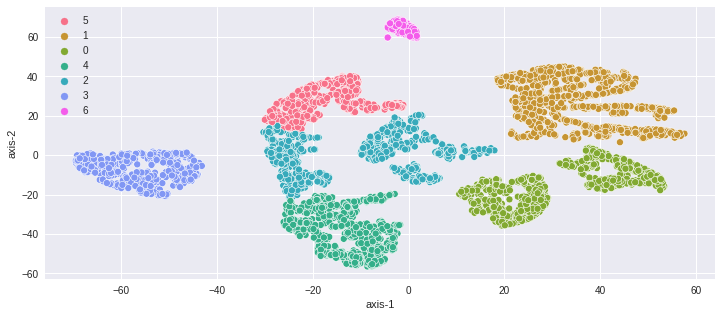

In [51]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=labels.astype('str'));

In [52]:
rfm_table_cleaned['labels'] = labels.values
rfm_table_cleaned.groupby('labels').mean().round(0)

Monetary  Frequency  Recency
labels                              
0          967.0        3.0     44.0
1         2418.0        7.0     33.0
2          546.0        2.0    169.0
3          547.0        2.0     38.0
4          331.0        1.0     46.0
5          351.0        1.0    283.0
6          236.0        1.0    365.0

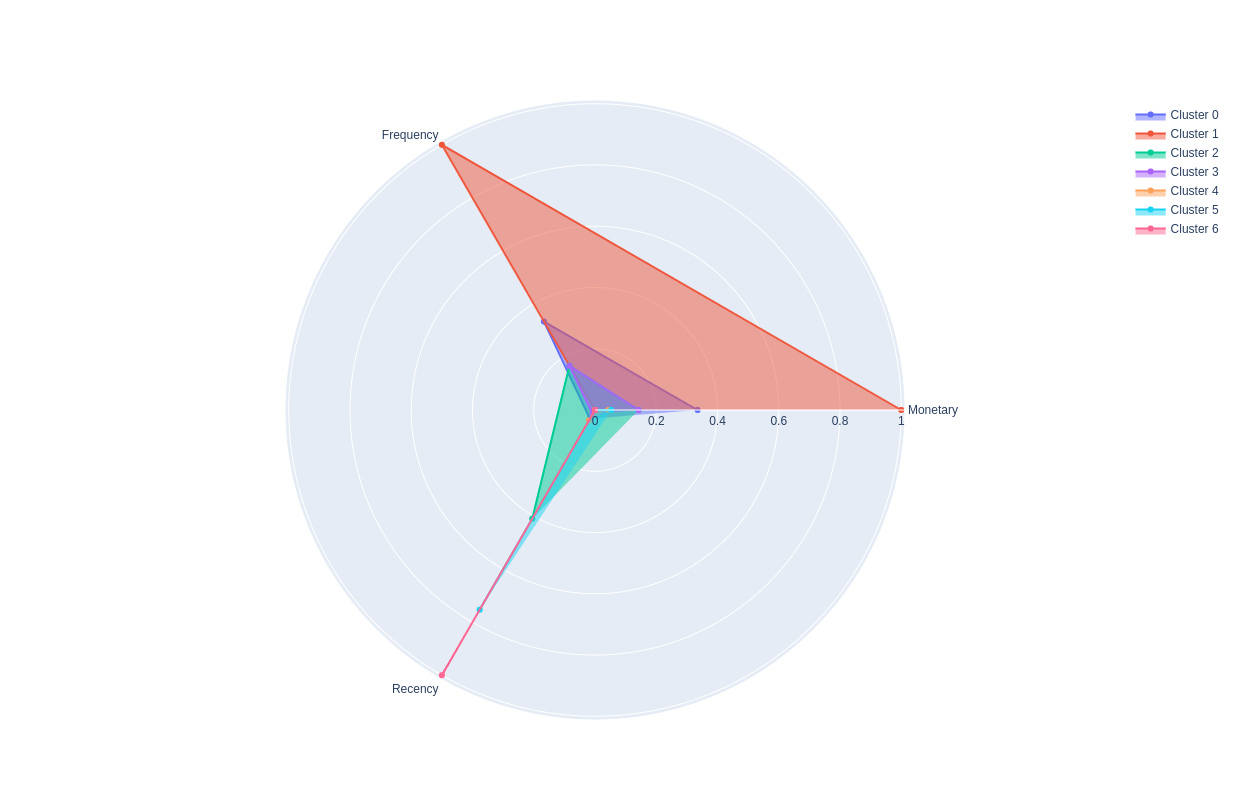

In [53]:
plot_cluster_profile(rfm_table_cleaned.groupby('labels').mean().round(0), 7) 

In [54]:
from sklearn.model_selection import train_test_split

X = rfm_table_cleaned.drop(['labels'], axis=1)
y = rfm_table_cleaned['labels'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_test.shape[0]

809

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

model = GridSearchCV(
    estimator = RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    n_jobs = -1
)

model.fit(X_train, y_train)
model.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}

In [56]:
from sklearn import metrics

y_pred = model.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

0.9876390605686032


In [57]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

cv_model = GridSearchCV(
    estimator = GradientBoostingClassifier(random_state=42),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5
)

cv_model.fit(X_train, y_train)

y_pred = cv_model.predict(X_test)
print(cv_model.best_params_)
print(metrics.accuracy_score(y_test, y_pred))

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
0.9888751545117429


In [58]:
gb_model = GradientBoostingClassifier(**cv_model.best_params_, random_state=42)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9888751545117429
